## DatasetBase Usage

In [1]:
import sys
import os
# to import CAMUSDataset class from dataset_camus file
camus_dataset_dir = os.path.abspath('../dataset')
sys.path.append(camus_dataset_dir)
from dataset_camus import CAMUSDataset

# to import PreProcess from 'model' file
model_dir = os.path.abspath('../model')
sys.path.append(model_dir)
from pre_processing import PreProcessor

# to import load config files
utils_dir = os.path.abspath('../utils')
sys.path.append(utils_dir)
from handling_yaml import load_config_file

import numpy as np
import matplotlib.pyplot as plt

### Building a generator with the parameters listed below:
1. batch size = 100
2. input size = (128, 128)
3. shuffle = True
4. n_channels = 1
5. split_ratio = 0.9

In [2]:
config_path = "../config/config_example.yaml"
config = load_config_file(config_path)
dataset = CAMUSDataset(config)

train_gen, val_gen, n_iter_train, n_iter_val= dataset.create_data_generators()

### Displaying random images from the given dataset

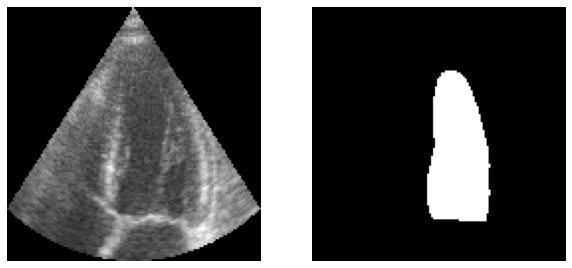

In [3]:
train_gen.random_visualization()

### Pre-processing

In [4]:
pre_processor = PreProcessor()

train_gen = pre_processor.add_preprocess(train_gen)
val_gen = pre_processor.add_preprocess(val_gen)

### Plotting the first image of train set batches and their labels map

iterating through the dataset by batches with 
> ### __*next()*__


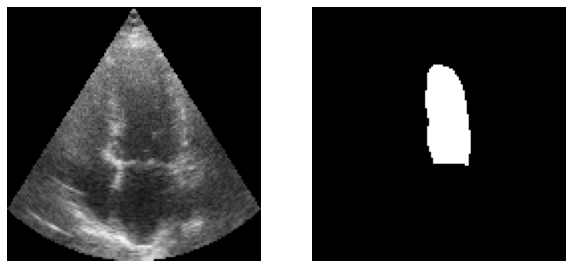

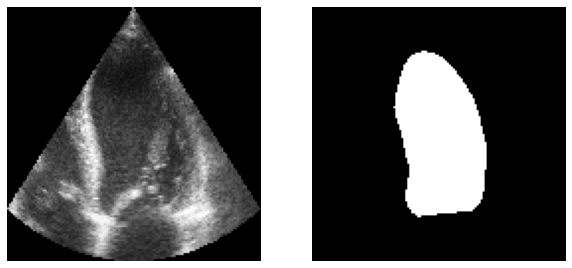

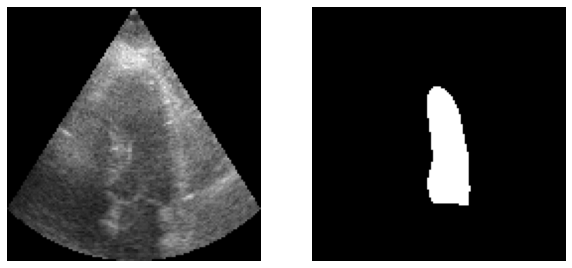

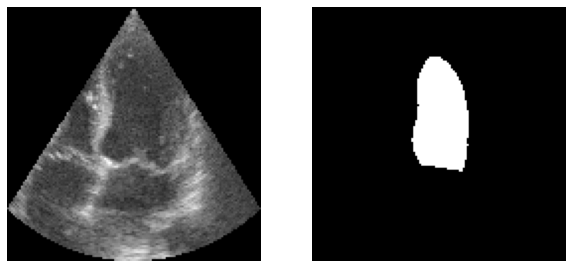

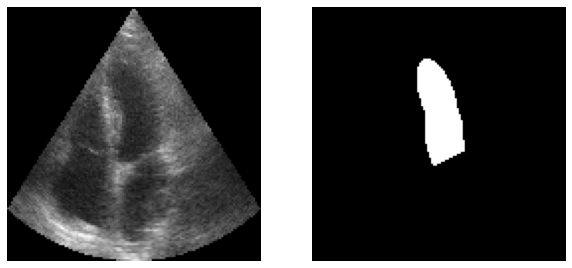

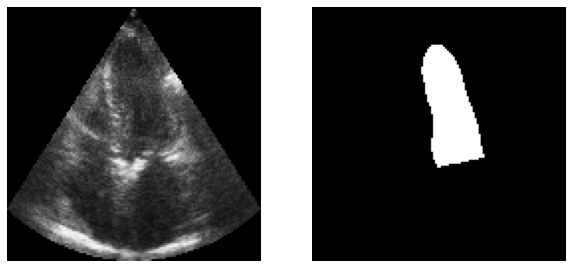

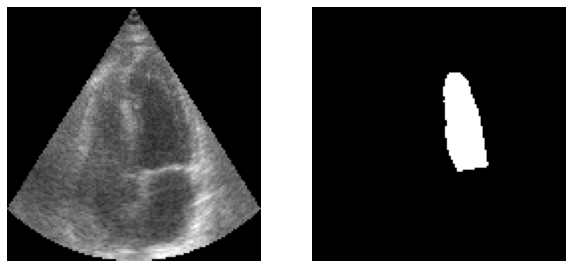

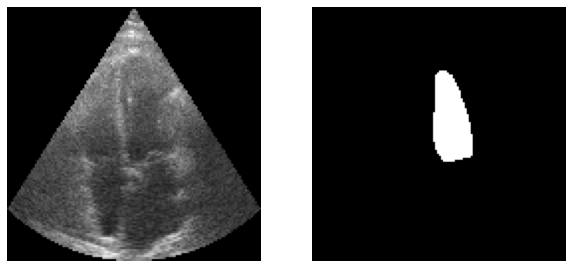

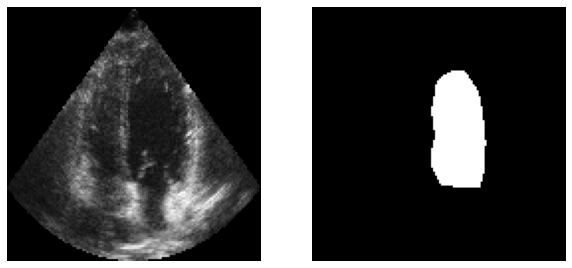

In [5]:
for i in range(n_iter_train):
    item = next(train_gen)
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    ax[0].imshow(item[0][0], cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(item[1][0], cmap='gray')
    ax[1].axis('off')
    plt.show()

### Using U-net segmentation pre-trained model for CAMUS dataset

In [6]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.losses import dice_loss
from segmentation_models.metrics import iou_score

sm.set_framework("tf.keras")

Segmentation Models: using `keras` framework.


#### Model Creation

In [7]:
model = Unet(
    'resnet34',
    input_shape=(128, 128, 1),
    classes=1,
    activation='sigmoid',
    encoder_freeze=False,
    encoder_weights=None
)

#### Model Compiling

In [8]:
model.compile(optimizer='Adam', 
              loss=dice_loss, 
              metrics=[iou_score])

#### Model Training

In [9]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = os.path.abspath('echotrain/checkpoints').replace('\\','/')
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [10]:
model_hist = model.fit(train_gen, 
          steps_per_epoch=n_iter_train, 
          epochs=3,
          callbacks=[model_checkpoint_callback],
          validation_data=val_gen,
          validation_steps=n_iter_val)

Epoch 1/3
9/9 [==============================] - 159s 17s/step - loss: 0.6699 - iou_score: 0.2009 - val_loss: 0.8325 - val_iou_score: 0.0914
Epoch 2/3
9/9 [==============================] - 152s 17s/step - loss: 0.5156 - iou_score: 0.3189 - val_loss: 0.8313 - val_iou_score: 0.0921